In [26]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os 
import imghdr
import  numpy as np

#### 1 Cleaning the images 


In [5]:
# Limiting tensorflow on GPU usage 
gpus = tf.config.experimental.list_physical_devices('GPU')
for i in gpus:
    tf.config.experimental.set_memory_growth(i, True)

In [11]:
list_ext = ['jpeg','bmp','png','jpg']

In [9]:
img_folder = 'images'
dir_img = os.listdir(img_folder)

### Checking for right extentions 

In [16]:
for mood_class in dir_img:
    for img in os.listdir(os.path.join(img_folder,mood_class)):
        path = os.path.join(img_folder,mood_class,img)
        try:
            open = cv2.imread(path)
            ex = imghdr.what(path)
            if not ex in list_ext:
                os.remove(path)
                print(f"One image was removed : {img}")
        except:
            os.remove(path)
            print(f"Issue with data {img}")

In [24]:
one = cv2.imread(os.path.join(img_folder,'happy','15_0511_pura_vida-0045-900x600.jpg'))


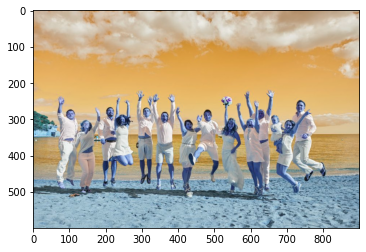

In [22]:
plt.imshow(one)

## load data


#### albeling the data


In [68]:
data  = tf.keras.utils.image_dataset_from_directory(img_folder,batch_size= 16)


Found 270 files belonging to 2 classes.


##### getting the data


In [47]:
data_itr = data.as_numpy_iterator()
batch = data_itr.next()


##### plotting images to see lables


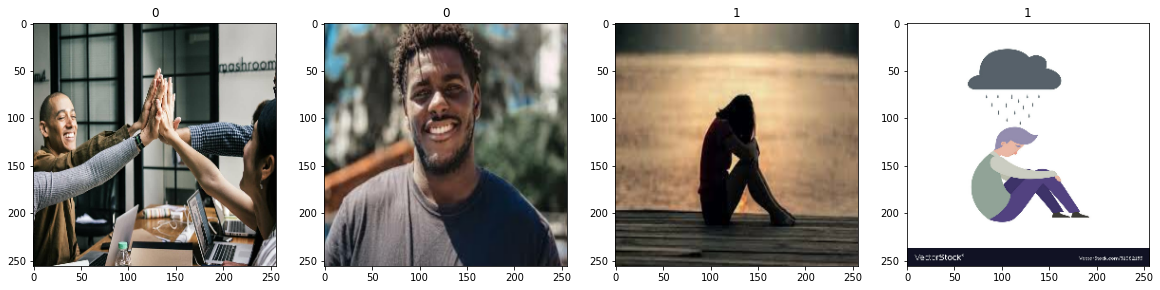

In [48]:
# 1 -> sad 2-> happy
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx , img  in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocessing

In [56]:
(batch[0] / 255).max()

1.0

##### Scaling images 


In [69]:
data = data.map(lambda x,y: (x/255,y))

In [70]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

##### Splitting the data

In [79]:
len(data)

17

In [78]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

17


##### Actual data splitting 

In [80]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


### Deep learning